In [ ]:
from google.colab import files
uploaded = files.upload()

import io, json
import pandas as pd

file_name = list(uploaded.keys())[0]
data = [json.loads(line) for line in io.StringIO(uploaded[file_name].decode('utf-8'))]
df = pd.DataFrame(data)
df.head()

Saving politifact_factcheck_data.json to politifact_factcheck_data.json


,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,Adriel Bettelheim,6/16/2008,https://www.politifact.com/factchecks/2008/jun...
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,Clay Wirestone,5/27/2016,https://www.politifact.com/factchecks/2016/may...
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,Madison Czopek,2/5/2021,https://www.politifact.com/factchecks/2021/feb...
4,half-true,Bobby Jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,Linda Qiu,8/30/2015,https://www.politifact.com/factchecks/2015/aug...


In [ ]:

# Binary Labeling
real_labels = ["true", "mostly-true"]
fake_labels = ["false", "pants-fire", "barely-true"]

#'half-true'제외
df_filtered = df[~df["verdict"].isin(["half-true", "mostly-false"])].copy()

# binary label
df_filtered["label"] = df_filtered["verdict"].apply(lambda x: 1 if x in fake_labels else 0)

# label distribution
df_filtered["label"].value_counts()


,count
label,
1,8328
0,5795


In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered["label"], random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, stratify=val_df["label"], random_state=42)
print(len(train_df), len(val_df), len(test_df))

11298 1412 1413


In [ ]:
# 감성 점수
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model.eval()
model = model.to('cuda')

def get_sentiment_scores(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to('cuda')
    with torch.no_grad():
        outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()[0]
    return scores


train_df[['sent_neg', 'sent_neu', 'sent_pos']] = np.array([get_sentiment_scores(text) for text in tqdm(train_df['statement'])])
val_df[['sent_neg', 'sent_neu', 'sent_pos']] = np.array([get_sentiment_scores(text) for text in tqdm(val_df['statement'])])
test_df[['sent_neg', 'sent_neu', 'sent_pos']] = np.array([get_sentiment_scores(text) for text in tqdm(test_df['statement'])])


100%|██████████| 1413/1413 [00:12<00:00, 116.51it/s]


In [ ]:
# 문장 임베딩
from sentence_transformers import SentenceTransformer
sbert = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device='cuda')

X_bert_train = sbert.encode(train_df['statement'].tolist(), show_progress_bar=True)
X_bert_val = sbert.encode(val_df['statement'].tolist(), show_progress_bar=True)
X_bert_test = sbert.encode(test_df['statement'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/354 [00:00<?, ?it/s]

Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Batches:   0%|          | 0/45 [00:00<?, ?it/s]

In [ ]:
# 저자별 신용도? (강륜 님 아이디어)
originator_scores = train_df.groupby('statement_originator')['label'].mean().to_dict()
train_df['originator_avg_truth'] = train_df['statement_originator'].map(originator_scores).fillna(0.5)
val_df['originator_avg_truth'] = val_df['statement_originator'].map(originator_scores).fillna(0.5)
test_df['originator_avg_truth'] = test_df['statement_originator'].map(originator_scores).fillna(0.5)

X_originator_train = train_df[['originator_avg_truth']].values
X_originator_val = val_df[['originator_avg_truth']].values
X_originator_test = test_df[['originator_avg_truth']].values

In [ ]:
from sklearn.preprocessing import StandardScaler
bert_scaler = StandardScaler()
X_bert_train = bert_scaler.fit_transform(X_bert_train)
X_bert_val = bert_scaler.transform(X_bert_val)
X_bert_test = bert_scaler.transform(X_bert_test)

In [ ]:
# TF-IDF 클러스터 거리
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

tfidf_vec = TfidfVectorizer(max_features=1000)
X_tfidf_train = tfidf_vec.fit_transform(train_df['statement'])
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_tfidf_train)
train_labels = kmeans.predict(X_tfidf_train)
_, train_dists = pairwise_distances_argmin_min(X_tfidf_train, kmeans.cluster_centers_)

X_tfidf_val = tfidf_vec.transform(val_df['statement'])
val_labels = kmeans.predict(X_tfidf_val)
_, val_dists = pairwise_distances_argmin_min(X_tfidf_val, kmeans.cluster_centers_)

X_tfidf_test = tfidf_vec.transform(test_df['statement'])
test_labels = kmeans.predict(X_tfidf_test)
_, test_dists = pairwise_distances_argmin_min(X_tfidf_test, kmeans.cluster_centers_)

train_df['tfidf_cluster_dist'] = train_dists
val_df['tfidf_cluster_dist'] = val_dists
test_df['tfidf_cluster_dist'] = test_dists

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# 문체 + NER
import spacy
nlp = spacy.load("en_core_web_sm")
train_df['num_entities'] = [len(nlp(text).ents) for text in tqdm(train_df['statement'], desc="NER Train")]
val_df['num_entities'] = [len(nlp(text).ents) for text in tqdm(val_df['statement'], desc="NER Val")]
test_df['num_entities'] = [len(nlp(text).ents) for text in tqdm(test_df['statement'], desc="NER Test")]


train_df['word_count'] = train_df['statement'].apply(lambda x: len(x.split()))
val_df['word_count'] = val_df['statement'].apply(lambda x: len(x.split()))
test_df['word_count'] = test_df['statement'].apply(lambda x: len(x.split()))


NER Test: 100%|██████████| 1413/1413 [00:10<00:00, 134.15it/s]


In [ ]:
# Feature 결합
from sklearn.preprocessing import OneHotEncoder, StandardScaler

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_src_train = encoder.fit_transform(train_df[['statement_source']])
X_src_val = encoder.transform(val_df[['statement_source']])
X_src_test = encoder.transform(test_df[['statement_source']])

style_cols = ['word_count', 'num_entities']
scaler = StandardScaler()
X_style_train = scaler.fit_transform(train_df[style_cols])
X_style_val = scaler.transform(val_df[style_cols])
X_style_test = scaler.transform(test_df[style_cols])

X_sent_train = scaler.fit_transform(train_df[['sent_neg', 'sent_neu', 'sent_pos']])
X_sent_val = scaler.transform(val_df[['sent_neg', 'sent_neu', 'sent_pos']])
X_sent_test = scaler.transform(test_df[['sent_neg', 'sent_neu', 'sent_pos']])

X_clust_train = scaler.fit_transform(train_df[['tfidf_cluster_dist']])
X_clust_val = scaler.transform(val_df[['tfidf_cluster_dist']])
X_clust_test = scaler.transform(test_df[['tfidf_cluster_dist']])

import numpy as np
X_train_final = np.hstack([X_bert_train, X_sent_train, X_src_train, X_style_train, X_clust_train])
X_val_final = np.hstack([X_bert_val, X_sent_val, X_src_val, X_style_val, X_clust_val])
X_test_final = np.hstack([X_bert_test, X_sent_test, X_src_test, X_style_test, X_clust_test])
y_train_final = train_df['label'].values
y_val_final = val_df['label'].values
y_test_final = test_df['label'].values

In [ ]:
# PyTorch 학습
import torch
from torch.utils.data import TensorDataset, DataLoader
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_final, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_final, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_final, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_final, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
import torch.nn as nn
class MLPBatchNorm1D(nn.Module):
    def __init__(self, input_dim, dropout_ratios):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_ratios[0]),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_ratios[1]),

            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout_ratios[2]),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

DROPOUT_RATIOS = [0.5, 0.4, 0.3]
model = MLPBatchNorm1D(X_train_tensor.shape[1], DROPOUT_RATIOS)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 학습 루프
NUM_EPOCHS = 30
best_loss = float('inf')
best_model = None
early_stop = 5
epochs_no_improve = 0

for epoch in range(NUM_EPOCHS):
    train_losses = []
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    valid_losses = []
    model.eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb).squeeze()
            loss = criterion(preds, yb)
            valid_losses.append(loss.item())

    test_losses = []
    model.eval()
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb).squeeze()
            loss = criterion(preds, yb)
            test_losses.append(loss.item())

    avg_valid_loss = np.mean(valid_losses)
    avg_test_loss = np.mean(test_losses)
    print(f"Epoch {epoch+1} | Train Loss: {np.mean(train_losses):.4f} | Valid Loss: {avg_valid_loss:.4f} | Test loss: {avg_test_loss}")

    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_model = model
        epochs_no_improve = 0
        print("  --> Best model updated")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop:
            print("  --> Early stopping triggered")
            break



Epoch 1 | Train Loss: 0.5413 | Valid Loss: 0.5018 | Test loss: 0.5009657611017642
  --> Best model updated
Epoch 2 | Train Loss: 0.4986 | Valid Loss: 0.5100 | Test loss: 0.49693689398143603
  --> Best model updated
Epoch 3 | Train Loss: 0.4754 | Valid Loss: 0.4971 | Test loss: 0.4876067340373993
  --> Best model updated
Epoch 4 | Train Loss: 0.4554 | Valid Loss: 0.5064 | Test loss: 0.47904379601063934
  --> Best model updated
Epoch 5 | Train Loss: 0.4354 | Valid Loss: 0.5076 | Test loss: 0.4873199216697527
Epoch 6 | Train Loss: 0.4214 | Valid Loss: 0.5012 | Test loss: 0.481179622852284
Epoch 7 | Train Loss: 0.3980 | Valid Loss: 0.5121 | Test loss: 0.4850762965886489
Epoch 8 | Train Loss: 0.3864 | Valid Loss: 0.5283 | Test loss: 0.5052125466906506
Epoch 9 | Train Loss: 0.3701 | Valid Loss: 0.5223 | Test loss: 0.5145900573419488
  --> Early stopping triggered


In [ ]:
# 평가 (TF-IDF 포함 ver)
from sklearn.metrics import classification_report
best_model.eval()
with torch.no_grad():
    test_preds = best_model(X_test_tensor).round().squeeze()

print(classification_report(y_test_tensor, test_preds))


              precision    recall  f1-score   support

         0.0       0.71      0.70      0.70       580
         1.0       0.79      0.80      0.80       833

    accuracy                           0.76      1413
   macro avg       0.75      0.75      0.75      1413
weighted avg       0.76      0.76      0.76      1413



[*] MLP Final | AP = 0.887, AUROC = 0.830
--------------------------------------------------


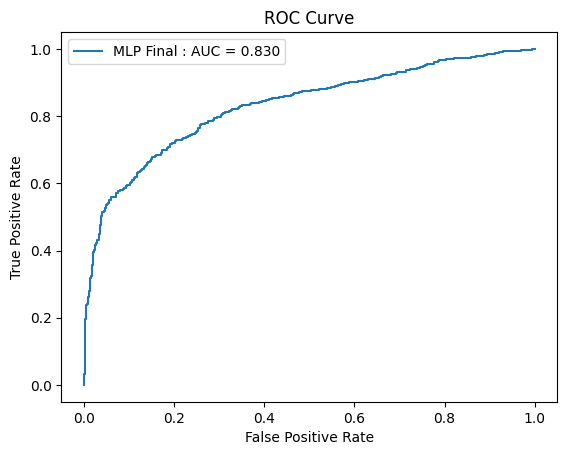

In [ ]:
# AUROC 평가용 코드
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

def evaluate_ap_and_auroc(test_labels, test_preds, exp_names):
    assert len(test_labels) == len(test_preds) == len(exp_names), "길이 불일치 오류"
    for labels, preds, exp_name in zip(test_labels, test_preds, exp_names):
        fpr, tpr, _ = roc_curve(labels, preds)
        auc = roc_auc_score(labels, preds)
        ap = average_precision_score(labels, preds)
        plt.plot(fpr, tpr, label=f'{exp_name} : AUC = {auc:.3f}')
        print(f"[*] {exp_name} | AP = {ap:.3f}, AUROC = {auc:.3f}")
    print("-" * 50)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

#  테스트셋 예측 확률값
best_model.eval()
with torch.no_grad():
    test_probs = best_model(X_test_tensor).squeeze().cpu().numpy()  # 확률값


exp_names = ['MLP Final']
test_preds = [test_probs]
test_labels = [y_test_tensor.cpu().numpy()]

evaluate_ap_and_auroc(test_labels, test_preds, exp_names)


In [ ]:
np.save('final_test_probs.npy', best_model(X_test_tensor).detach().cpu().numpy())


In [ ]:
torch.save(best_model.state_dict(), "best_model.pt")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import torch
import os

# 저장 경로 설정
save_path = "/content/drive/MyDrive/fakenews_results"
os.makedirs(save_path, exist_ok=True)

# 예측 확률 저장
np.save(f"{save_path}/final_test_probs.npy", best_model(X_test_tensor).detach().cpu().numpy())

# 모델 가중치 저장
torch.save(best_model.state_dict(), f"{save_path}/best_model.pt")


Mounted at /content/drive


NameError: name 'best_model' is not defined

In [ ]:
!ls /content/drive/MyDrive/fakenews_results


In [ ]:
!pip install lightgbm


In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report

# LightGBM Dataset 생성
lgb_train = lgb.Dataset(X_train_final, label=y_train_final)
lgb_val = lgb.Dataset(X_val_final, label=y_val_final, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'random_state': 42
}

print("LightGBM 학습 시작")
lgb_model = lgb.train(params, lgb_train, valid_sets=[lgb_val],
                      num_boost_round=200, callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True)])


# 예측 및 평가
y_pred_lgb = (lgb_model.predict(X_val_final) >= 0.5).astype(int)
print("LightGBM 성능 평가")
print(classification_report(y_val_final, y_pred_lgb, digits=4))



LightGBM 학습 시작
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.501209
LightGBM 성능 평가
              precision    recall  f1-score   support

           0     0.8208    0.7311    0.7733       833
           1     0.6657    0.7703    0.7142       579

    accuracy                         0.7472      1412
   macro avg     0.7432    0.7507    0.7438      1412
weighted avg     0.7572    0.7472    0.7491      1412

